In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

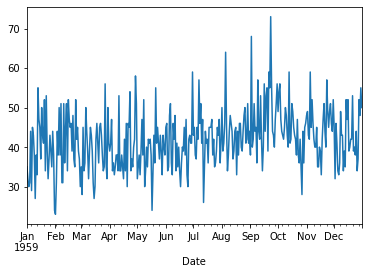

In [2]:
df = pd.read_csv("data/daily-total-female-births.csv", header=0, index_col=0, parse_dates=True, squeeze=True)
df.plot()
plt.show()

test RMSE: 9.151


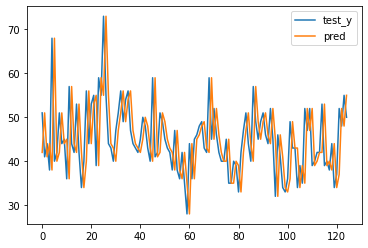

In [3]:
# baseline-model
values = pd.DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

predictions = [x for x in test_X]

rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('test RMSE: %.3f' %rmse)

plt.plot(test_y, label='test_y')
plt.plot(predictions, label='pred')
plt.legend()
plt.show()

In [4]:
# residuals
residuals = [test_y[i] - predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
print(residuals.head())

      0
0   9.0
1 -10.0
2   3.0
3  -6.0
4  30.0


In [5]:
# autoRegression of residual error
from statsmodels.tsa.ar_model import AR
values = pd.DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# baseline model on training set
train_pred = [x for x in train_X]
# residuals of training predictions
train_resid = [train_y[i] - train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag: %d, Coef=%s' %(window, coef))

Lag: 15, Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


C:\Users\desktop\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


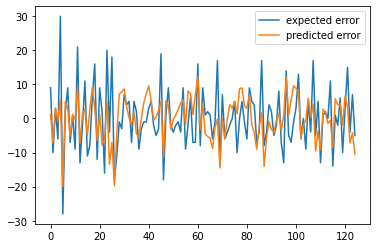

In [6]:
# testdataset and predict the residual error
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()

for t in range(len(test_y)):
    # baseline
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    #print('predicted error: %f, expected error: %f' %(pred_error, error))

plt.plot(expected_error, label='expected error')
plt.plot(predictions, label='predicted error')
plt.legend()
plt.show()

Test RMSE: 7.499


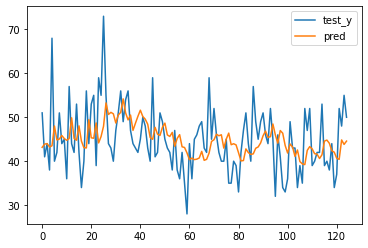

In [7]:
# correct predictions with model of residuals
# improved forecast = forecast + estimated error

values = pd.DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# baseline model on training set
train_pred = [x for x in train_X]

# residuals of training predictions
train_resid = [train_y[i] - train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    #print('predicted=%f, expected=%f' % (yhat, test_y[t]))
    
# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

# plot predicted error
plt.plot(test_y, label='test_y')
plt.plot(predictions, label='pred')
plt.legend()
plt.show()